# How many tiled MatMul do we need?
Given that matmul is our limiting operation, how many tiled matmul do we need to process a Bert layer?

Assumptions:
- Adding partial sum matrices is free
- Adding bias from linear layers is free
- Moving data to the input of the tiled matmul is fully overlapped with computation (probably realistic with pingpong buffers) 

In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt

class MatrixMultiplier:
    def __init__(self, tile, cycles_per_tile, clock_freq):
        self.tile = tile
        self.cycles_per_tile = cycles_per_tile
        self.clock_freq = clock_freq
        
        self.total_tiled_muls = 0
        self.total_cycles = 0
        
    def mul(self, a, b):
        M = a.size()[-2]
        K = a.size()[-1]
        N = b.size()[-1]
        assert b.size()[-2] == K, f'a size {a.size()} b size {b.size()}'
        
        M_blocks = math.ceil(M / self.tile)
        K_blocks = math.ceil(K / self.tile)
        N_blocks = math.ceil(N / self.tile)
        
        n_tiled_mul = M_blocks * K_blocks * N_blocks
        
        self.total_tiled_muls += n_tiled_mul
        self.total_cycles += n_tiled_mul*self.cycles_per_tile
        
        return torch.matmul(a, b)
        
    def summary(self):
        print('-'*10)
        print(f'Using {self.tile}x{self.tile} tiled matrix multiplication:')
        print(f'{self.total_tiled_muls} tiled matmul in total')
        print(f'{self.total_cycles} total cycles')
        print(f'{self.total_cycles / self.clock_freq} seconds of latency at {self.clock_freq/1e6} MHz')
        print(f'{self.clock_freq / self.total_cycles} FPS layer throughput')
        print('-'*10)
        

In [3]:
def attention(mm, layer, hidden_states):
    '''
    hidden_states: <bs, seqlen, dmodel>
    '''
    bs, seqlen, dmodel = hidden_states.size()
    num_heads = layer.attention.self.num_attention_heads
    dhead = layer.attention.self.attention_head_size
    
    # Linear transform to get multiple heads. This is a major MAC slurper.
#     query_layer = layer.attention.self.query(hidden_states) # <bs, seqlen, dmodel>
    query_layer = mm.mul(hidden_states, layer.attention.self.query.weight.data.T)
#     key_layer = layer.attention.self.key(hidden_states)     # <bs, seqlen, dmodel>
    key_layer = mm.mul(hidden_states, layer.attention.self.key.weight.data.T)
#     value_layer = layer.attention.self.value(hidden_states) # <bs, seqlen, dmodel
    value_layer = mm.mul(hidden_states, layer.attention.self.value.weight.data.T)
    
    # Reshape and transpose for multi-head
    new_shape = (bs, seqlen, num_heads, dhead)
    
    query_layer = query_layer.view(new_shape)
    key_layer = key_layer.view(new_shape)
    value_layer = value_layer.view(new_shape)
    
    query_layer = query_layer.permute(0,2,1,3) # <bs, num_head, seqlen, dhead>
    key_layer = key_layer.permute(0,2,3,1)     # <bs, num_head, dhead, seqlen>
    value_layer = value_layer.permute(0,2,1,3) # <bs, num_head, seqlen, dhead>
    
    # The attention main course
    attention_scores = mm.mul(query_layer, key_layer)
    attention_scores /= math.sqrt(dhead)
    
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)
    attention_probs = layer.attention.self.dropout(attention_probs)
    
    attention_out = mm.mul(attention_probs, value_layer)
    
    attention_out = attention_out.permute(0,2,1,3).contiguous()
    attention_out = attention_out.view(bs, seqlen, dmodel)
    
    # It's time for one more linear transform and layer norm
    dense_out = mm.mul(attention_out, layer.attention.output.dense.weight.data.T)
    dense_out = layer.attention.output.dropout(dense_out)
    # Implements the residual connection
    layer_out = layer.attention.output.LayerNorm(dense_out + hidden_states)
    
    return layer_out

def ffn(mm, layer, attention_out):
    
    # Layer 1
    output = mm.mul(attention_out, layer.intermediate.dense.weight.data.T)
    output = nn.functional.gelu(output)
    
    # Layer 2
    output = mm.mul(output, layer.output.dense.weight.data.T)
    output = layer.output.dropout(output)
    output = layer.output.LayerNorm(output + attention_out)
    
    return output

In [4]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
model = BertModel.from_pretrained('bert-base-uncased')
layer = model.encoder.layer[0]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def measure(mm):
    fake_in = torch.zeros(1, 512, 768)
    attn_out = attention(mm, layer, fake_in)
    ffn_out = ffn(mm, layer, attn_out)
    mm.summary()

In [8]:
mm64 = MatrixMultiplier(tile=64, cycles_per_tile=(64+31), clock_freq=300e6)
measure(mm64)

----------
Using 64x64 tiled matrix multiplication:
13952 tiled matmul in total
1325440 total cycles
0.0044181333333333335 seconds of latency at 300.0 MHz
226.33993239980686 FPS layer throughput
----------


# 4 Stage Pipeline

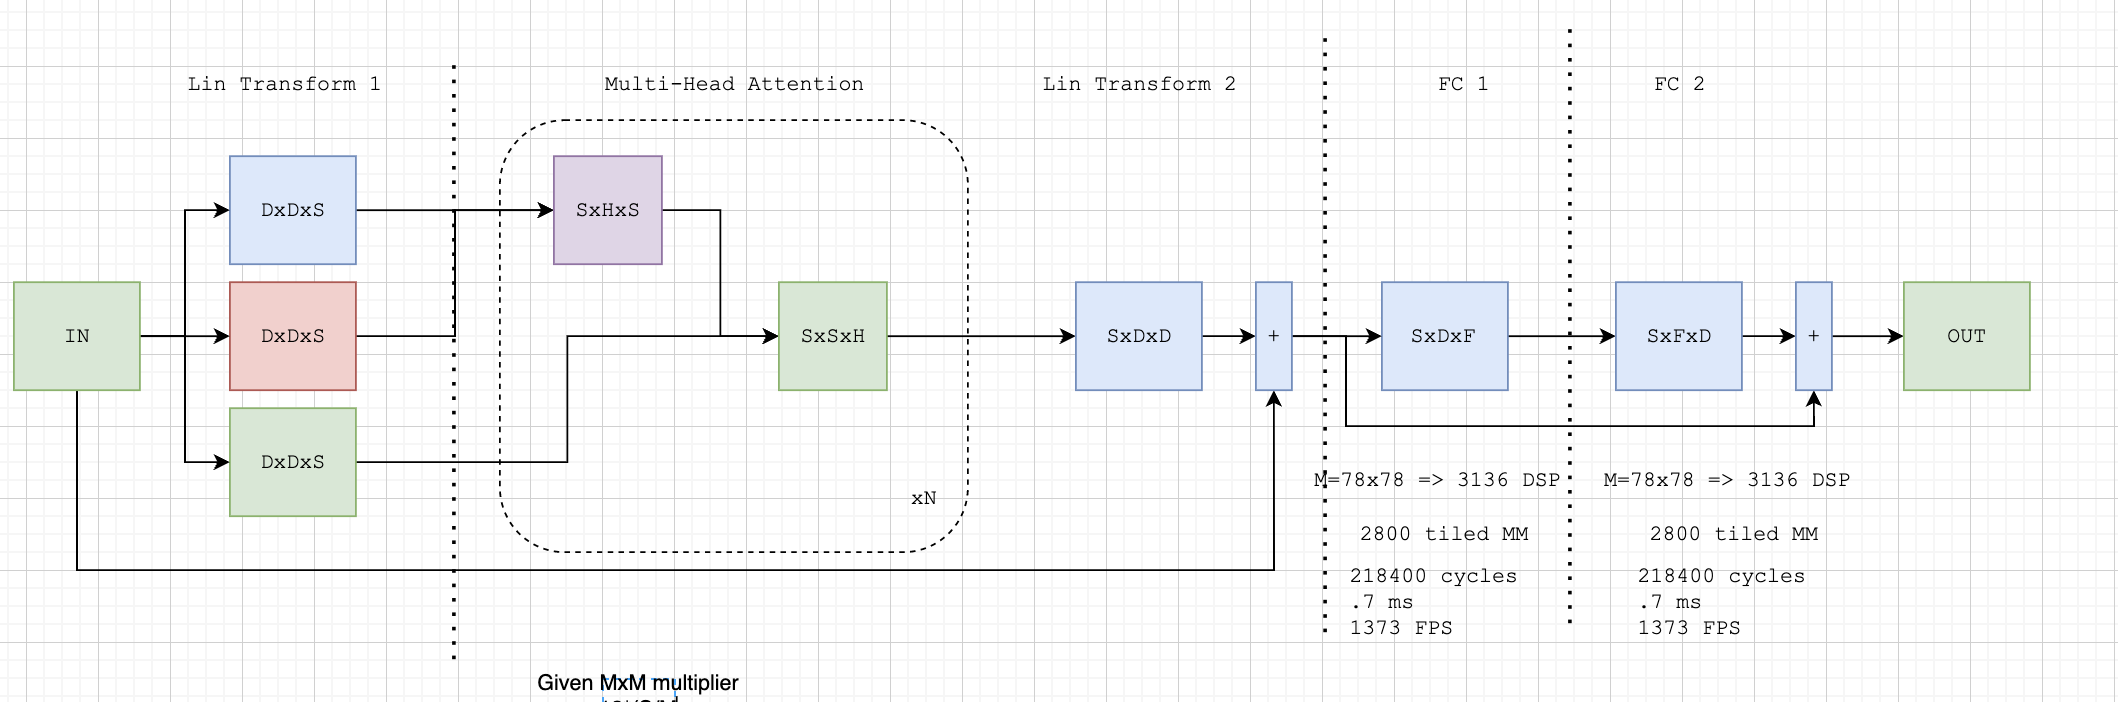

Design a 4-stage pipeline. Allocate resources to FC1 and FC2 first, since they are the major MAC users. Assume that an MxM matrix multiplication tile takes M cycles to be computed. Try different sequence lengths to find a compromise between usability and performance.

In [86]:
D = 768
S = 128
H = 64
N = 12
F = 3072
freq = 300e6

DSP = 6840
PE = DSP*2 # double count DSPs for 2 INT8 muls

In [99]:
(S*D+D*F/2+(S*F/2)*4+S*D+D*(F/2)+(S*F)*4) / 2**20

4.6875

In [87]:
'''
Stage 3 and 4 tile design
'''
M3 = np.arange(32, 82)
stage3_mm = np.ceil(S/M3)*np.ceil(D/M3)*np.ceil(F/M3)
stage3_cycles = stage3_mm * M3
stage3_fps = freq / stage3_cycles

# print(f'We can afford up to {math.floor((PE/2)**.5)} tile size with {PE//2} PEs in stage 3.')
# print(f'77x77 PEs gives the most bang for buck: {stage3_cycles[M3==77][0]} cycles')
# print(f'DSP Utilization: {2*(77**2)//2}')
print(f'BRAM Utilization across both stages: {(S*D*2+D*F+S*F+S*F*2+F*D+S*D)/1e6} MB')

BRAM Utilization across both stages: 6.193152 MB


In [88]:
'''
Stage 2 design 
'''
M2 =  np.arange(32, 82)
stage2_mm = N*(np.ceil(S/M2)**2*np.ceil(H/M2)*2) + np.ceil(S/M2)*np.ceil(D/M2)**2
stage2_cycles = stage2_mm * M2
stage2_fps = freq / stage2_cycles

In [89]:
'''
Stage 1 design
'''
M1 = np.arange(32, 82)
stage1_mm = 3*np.ceil(D/M1)**2*np.ceil(S/M1)
stage1_cycles = stage1_mm * M1
stage1_fps = freq / stage1_cycles

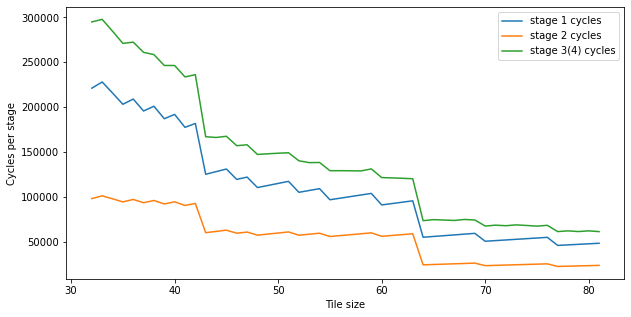

In [90]:
plt.figure(figsize=(10,5))
plt.plot(M1, stage1_cycles, label='stage 1 cycles')
plt.plot(M2, stage2_cycles, label='stage 2 cycles')
plt.plot(M3, stage3_cycles, label='stage 3(4) cycles')
plt.xlabel('Tile size')
plt.ylabel('Cycles per stage')
plt.legend()
plt.show()

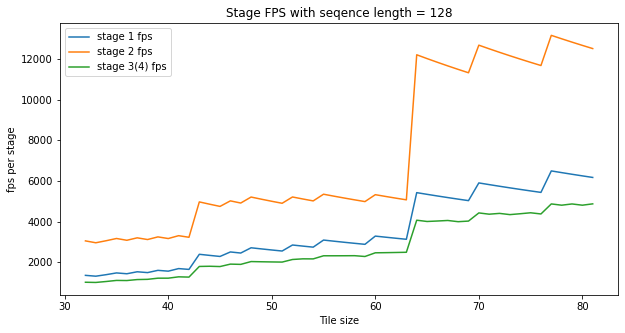

In [91]:
plt.figure(figsize=(10,5))
plt.plot(M1, stage1_fps, label='stage 1 fps')
plt.plot(M2, stage2_fps, label='stage 2 fps')
plt.plot(M3, stage3_fps, label='stage 3(4) fps')
plt.xlabel('Tile size')
plt.ylabel('fps per stage')
# plt.plot(M1, np.ones_like(M1)*1250)
plt.title(f'Stage FPS with seqence length = {S}')
plt.legend()
plt.show()

In [77]:
stage3_cycles[M3 == 74]

array([239316.])

In [15]:
300e6 / 239316

1253.5726821441108

In [16]:
74*74/2

2738.0